In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from scipy import stats


In [2]:
combined_df = pd.read_csv('../data/unified_percipitation_data.csv')

In [3]:
#removing missing years
combined_df = combined_df[(combined_df['year'] != 1996) & (combined_df['year'] != 1995)]

### Feature Engineering

In [4]:
combined_df['date'] = pd.to_datetime(combined_df['date'])

In [5]:
def rolling_mean(df):
    df['precip_rolling_mean'] = df['precipitation'].rolling(3).mean()
    return df

In [6]:
combined_df = rolling_mean(combined_df)

In [7]:
combined_df.head()

,date,year,month,day,network,country,station_id,latitude,longitude,station_occurrence,precipitation,quality_flag,qc_code,obs_hour,season,precip_rolling_mean
0,1997-08-01,1997,8,1,COSTA,RICA,96001,9.30000,-83.78334,0,6.8,0,U,13,Non-Harvest Season,NaN
1,1997-08-01,1997,8,1,COSTA,RICA,92002,9.40000,-84.08334,0,51.4,0,U,13,Non-Harvest Season,NaN
2,1997-08-01,1997,8,1,COSTA,RICA,90003,9.43333,-84.15000,0,31.3,0,U,13,Non-Harvest Season,29.833333
3,1997-08-01,1997,8,1,COSTA,RICA,90007,9.50000,-84.21667,0,26.5,0,U,13,Non-Harvest Season,36.400000
4,1997-08-01,1997,8,1,COSTA,RICA,90005,9.50000,-84.15000,0,23.4,0,U,13,Non-Harvest Season,27.066667


In [8]:
#rolling mean for previous months.
for lag in range(1, 4):
    combined_df[f'precipitation_lag_{lag}'] = combined_df['precipitation'].shift(lag)
combined_df.dropna(inplace=True)

In [9]:
def add_seasonal_features(data):
    data['month_sin'] = np.sin(2 * np.pi * data['month']/12)
    data['month_cos'] = np.cos(2 * np.pi * data['month']/12)
    return data

In [10]:
def add_station_features(data):
    data['latitude_normalized'] = (data['latitude'] - data['latitude'].mean()) / data['latitude'].std()
    data['longitude_normalized'] = (data['longitude'] - data['longitude'].mean()) / data['longitude'].std()
    return data

In [11]:
def assign_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

In [12]:
combined_df['season'] = combined_df['month'].apply(assign_season)

In [13]:
#ONE HOT ENCODING
combined_df = pd.get_dummies(combined_df, columns=['season'])

In [14]:
combined_df = add_seasonal_features(combined_df)

In [15]:
combined_df = add_station_features(combined_df)

In [16]:
combined_df.dropna(inplace=True)

In [17]:
combined_df.head()

,date,year,month,day,network,country,station_id,latitude,longitude,station_occurrence,...,precipitation_lag_2,precipitation_lag_3,season_fall,season_spring,season_summer,season_winter,month_sin,month_cos,latitude_normalized,longitude_normalized
3,1997-08-01,1997,8,1,COSTA,RICA,90007,9.50000,-84.21667,0,...,51.4,6.8,False,False,True,False,-0.866025,-0.5,-0.608298,0.186829
4,1997-08-01,1997,8,1,COSTA,RICA,90005,9.50000,-84.15000,0,...,31.3,51.4,False,False,True,False,-0.866025,-0.5,-0.608298,0.306961
5,1997-08-01,1997,8,1,COSTA,RICA,90001,9.51667,-84.25000,0,...,26.5,31.3,False,False,True,False,-0.866025,-0.5,-0.572565,0.126772
6,1997-08-01,1997,8,1,COSTA,RICA,88004,9.53333,-84.30000,0,...,23.4,26.5,False,False,True,False,-0.866025,-0.5,-0.536853,0.036678
7,1997-08-01,1997,8,1,COSTA,RICA,86007,9.70000,-84.66666,0,...,9.2,23.4,False,False,True,False,-0.866025,-0.5,-0.179589,-0.624004


In [18]:
print(combined_df.dtypes)


date                    datetime64[ns]
year                             int64
month                            int64
day                              int64
network                         object
country                         object
station_id                       int64
latitude                       float64
longitude                      float64
station_occurrence               int64
precipitation                  float64
quality_flag                     int64
qc_code                         object
obs_hour                         int64
precip_rolling_mean            float64
precipitation_lag_1            float64
precipitation_lag_2            float64
precipitation_lag_3            float64
season_fall                       bool
season_spring                     bool
season_summer                     bool
season_winter                     bool
month_sin                      float64
month_cos                      float64
latitude_normalized            float64
longitude_normalized     

### Modelling

In [19]:
def prepare_time_series_data(data, look_back=12):
    """
    Convierte un DataFrame en secuencias de datos para un modelo LSTM.
    - data: DataFrame con las características y la variable objetivo.
    - look_back: cantidad de pasos atrás usados para predecir.
    
    Retorna:
    - X: datos de entrada en forma de secuencias (samples, time_steps, features).
    - y: valores objetivo correspondientes.
    - scaler: objeto para reescalar datos.
    """
    # Normalizar datos
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back), :-1])  
        y.append(scaled_data[i + look_back, -1]) #last should be precip
    
    return np.array(X), np.array(y), scaler

In [20]:
LOOK_BACK = 6

In [21]:
combined_df.columns

Index(['date', 'year', 'month', 'day', 'network', 'country', 'station_id',
       'latitude', 'longitude', 'station_occurrence', 'precipitation',
       'quality_flag', 'qc_code', 'obs_hour', 'precip_rolling_mean',
       'precipitation_lag_1', 'precipitation_lag_2', 'precipitation_lag_3',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'month_sin', 'month_cos', 'latitude_normalized',
       'longitude_normalized'],
      dtype='object')

In [22]:
FEATURES = ['year', 'month', 'day', 'obs_hour', 'precip_rolling_mean',
       'precipitation_lag_1', 'precipitation_lag_2', 'precipitation_lag_3',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'month_sin', 'month_cos', 'latitude_normalized',
       'longitude_normalized']

LABEL = ['precipitation']

In [23]:
combined_df.columns

Index(['date', 'year', 'month', 'day', 'network', 'country', 'station_id',
       'latitude', 'longitude', 'station_occurrence', 'precipitation',
       'quality_flag', 'qc_code', 'obs_hour', 'precip_rolling_mean',
       'precipitation_lag_1', 'precipitation_lag_2', 'precipitation_lag_3',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'month_sin', 'month_cos', 'latitude_normalized',
       'longitude_normalized'],
      dtype='object')

In [24]:
look_back = 12  
train_size = int(len(combined_df) * 0.7)

X, y, scaler = prepare_time_series_data(combined_df[FEATURES + LABEL], look_back)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Shape of X_train:", X_train.shape)  # (n_samples, look_back, n_features)
print("Shape of y_train:", y_train.shape)  # (n_samples,)

Shape of X_train: (19588, 12, 16)
Shape of y_train: (19588,)


In [25]:
#add a more robust model for this itaration.
#more layers and 64 input.

def create_lstm_model(look_back, n_features):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(look_back, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [26]:
n_features = X_train.shape[2]
model = create_lstm_model(look_back, n_features)

/Users/luses/.local/share/mise/installs/python/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [28]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 2/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 7/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 8/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 11/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 12/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

In [29]:
train_predict = model.predict(X_train)

613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [30]:
test_predict = model.predict(X_test)

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [31]:
def inverse_transform_predictions(scaler, predictions, n_features):
    """
    Inverse transforms predictions when the scaler was fitted on multiple features.
    
    Parameters:
    -----------
    scaler : MinMaxScaler
        The fitted scaler object
    predictions : array-like
        The predictions to inverse transform
    n_features : int
        The number of features the scaler was fitted on
        
    Returns:
    --------
    array-like
        The inverse transformed predictions for the target variable
    """
    dummy = np.zeros((predictions.shape[0], n_features))
    dummy[:, -1] = predictions.ravel()
    dummy = scaler.inverse_transform(dummy)
    return dummy[:, -1]

In [32]:
n_features = len(FEATURES) + 1  # +1 for the target variable
train_predict = inverse_transform_predictions(scaler, train_predict, n_features)
y_train_inv = inverse_transform_predictions(scaler, y_train, n_features)
y_test_inv = inverse_transform_predictions(scaler, y_test, n_features)
test_predict = inverse_transform_predictions(scaler, test_predict, n_features)

In [33]:
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 19.20
Test RMSE: 20.61


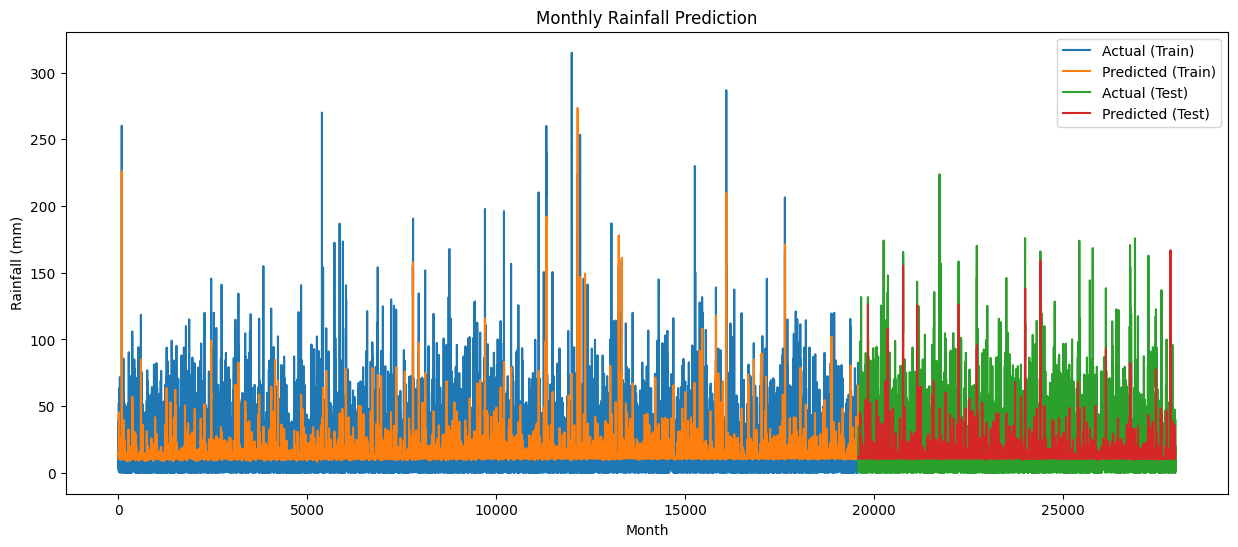

In [34]:
# 7. Visualize results
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(y_train_inv, label='Actual (Train)')
plt.plot(train_predict, label='Predicted (Train)')

plt.plot(range(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), 
         y_test_inv, label='Actual (Test)')
plt.plot(range(len(y_train_inv), len(y_train_inv) + len(test_predict)), 
         test_predict, label='Predicted (Test)')

plt.title('Monthly Rainfall Prediction')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()

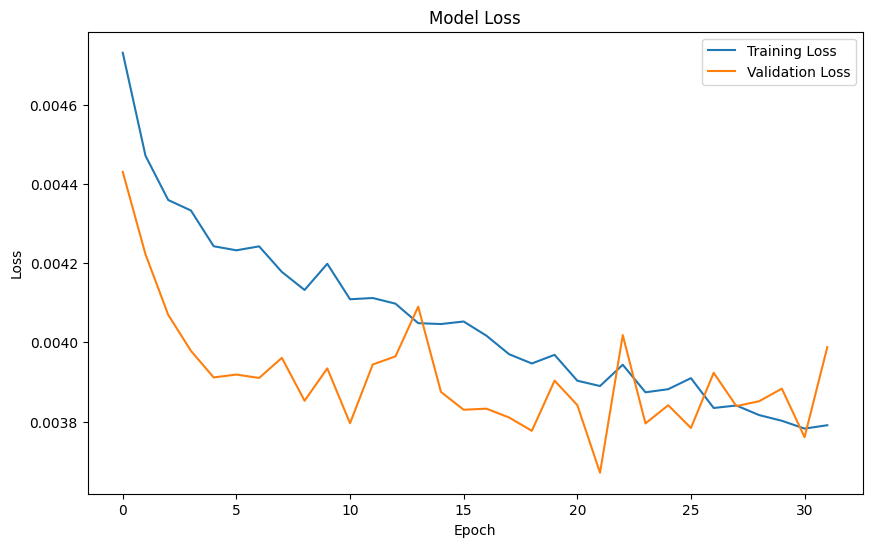

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Save the model

In [36]:
import joblib
import json
from pathlib import Path

# Create a directory for our model artifacts
Path("../models").mkdir(exist_ok=True)

# Save the LSTM model
model.save('../models/rainfall_lstm_model_v2.keras')

# Save the scaler
joblib.dump(scaler, '../models/scaler_v2.pkl')

# Save model metadata (like look_back period and other parameters)
model_metadata = {
    'look_back': look_back,
    'last_training_date': monthly_rain.index.max().strftime('%Y-%m-%d'),
    'input_features': ['precipitation'],
}
with open('../models/metadata_v2.json', 'w') as f:
    json.dump(model_metadata, f)

NameError: name 'monthly_rain' is not defined